In [16]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from autoviz.AutoViz_Class import AutoViz_Class
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
%matplotlib inline
plt.style.use('seaborn-white')


In [2]:
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M')
df = pd.read_csv('OnlineRetail.csv',parse_dates=['InvoiceDate'],date_parser=dateparse)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
#Check missing values
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
#Description is not needed 
df.drop('Description',axis=1,inplace=True)
#There are a lot missing customer Ids . These rows are useless, we will drop them
df.dropna(subset=['CustomerID'],inplace=True)

In [6]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

In [7]:
#Exploratory data analysis with Pandas Profiling
profile = ProfileReport(df,explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?

Frequency (F) as total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.

Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

In [8]:
df['PurchaseAmount'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PurchaseAmount
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [9]:
#Calculate total spent by customer and total orders
#Monetary (M) - Frequency (F)
spent_group = df.groupby('CustomerID')['PurchaseAmount'].sum()
spent_group.name = "Monetary"
total_orders_group = df.groupby('CustomerID')['InvoiceNo'].count()
total_orders_group.name = 'Frequency'
print(spent_group.head())
print(total_orders_group.head())

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
Name: Monetary, dtype: float64
CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
Name: Frequency, dtype: int64


In [10]:
#Recency (R) - days since last purchase
#We consider the last purchase date as "today" to calculate how recent was a customer's last purchase

last_purchase_date = df['InvoiceDate'].max()
last_purchase_date


Timestamp('2011-12-09 12:50:00')

In [11]:
group_last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()
group_recency =  last_purchase_date - group_last_purchase 
group_recency.name = 'Recency'
group_recency.dt.days

CustomerID
12346    325
12347      1
12348     74
12349     18
12350    309
        ... 
18280    277
18281    180
18282      7
18283      3
18287     42
Name: Recency, Length: 4372, dtype: int64

In [12]:
m_df = pd.DataFrame(spent_group)
rfm_df = m_df.merge(total_orders_group,left_index=True,right_index=True).merge(group_recency.dt.days,left_index=True,right_index=True)

In [13]:
rfm_df.head()

,Monetary,Frequency,Recency
CustomerID,,,
12346,0.00,2,325
12347,4310.00,182,1
12348,1797.24,31,74
12349,1757.55,73,18
12350,334.40,17,309


In [14]:
#Run exploratory data analysis again on the new dataframe
profile_rfm = ProfileReport(rfm_df,explorative=True)
profile_rfm.to_notebook_iframe()

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#The profiling showed some negative monetary values . We will exclude these records
rfm_df = rfm_df[rfm_df['Monetary'] > 0]

In [19]:
# Scaling
scaler = StandardScaler()
rf_scaled = scaler.fit_transform(rfm_df)

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [21]:
#Determine number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(rf_scaled)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(rf_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

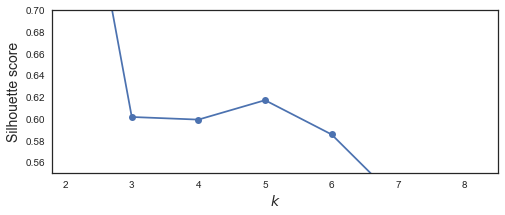

In [22]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [49]:
#Seems that 5 clusters is the optimal
kmeans = KMeans( n_clusters = 5)
preds = kmeans.fit_predict(rf_scaled)


<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

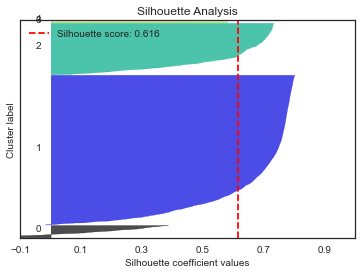

In [50]:

skplt.metrics.plot_silhouette(rf_scaled, preds)

In [51]:
pred_df = pd.DataFrame(preds,columns=['Cluster'])
pred_df


,Cluster
0,1
1,1
2,1
3,2
4,1
...,...
4317,2
4318,2
4319,1
4320,0


In [52]:
pred_df['Cluster'].value_counts()

1    3024
2    1040
0     249
3       5
4       4
Name: Cluster, dtype: int64

In [53]:
rfm_df['Cluster'] = pred_df.values
rfm_df

,Monetary,Frequency,Recency,Cluster
CustomerID,,,,
12347,4310.00,182,1,1
12348,1797.24,31,74,1
12349,1757.55,73,18,1
12350,334.40,17,309,2
12352,1545.41,95,35,1
...,...,...,...,...
18280,180.60,10,277,2
18281,80.82,7,180,2
18282,176.60,13,7,1


# Some plotting to show the clustering

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

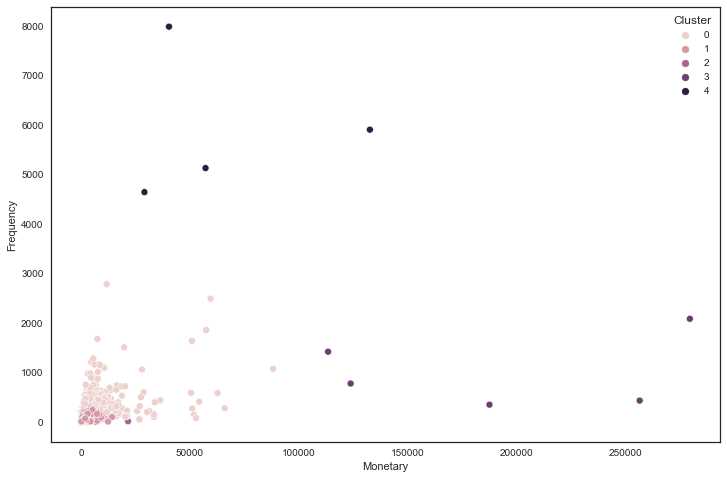

In [54]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Monetary'] ,
                rfm_df['Frequency'] , 
                hue = rfm_df['Cluster'] )

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

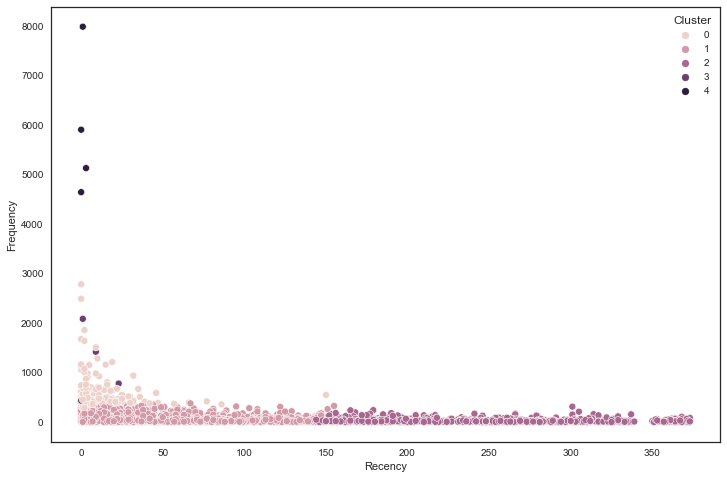

In [55]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Recency'] ,
                rfm_df['Frequency'] , 
                hue = rfm_df['Cluster'] )

<AxesSubplot:xlabel='Monetary', ylabel='Recency'>

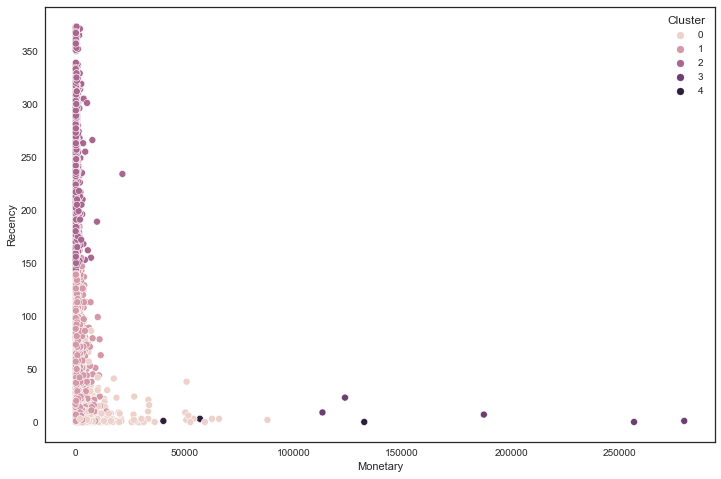

In [56]:
plt.figure(figsize=(12, 8))
sns.scatterplot(rfm_df['Monetary'] ,
                rfm_df['Recency'] , 
                hue = rfm_df['Cluster'] )

There are some obvious outliers , we can potentially do further preprocessing to remove outliers